# Differential Evolution For Digital Watermarking

In [1]:
import random
import cv2
import numpy as np
from DEwatermarking import watermarking
import test
from matplotlib import pyplot as plt

### Cost Function

In [2]:
def cost(x):
    Watermarking = watermarking(level=3, x = x)
    Watermarking.watermark()
    Watermarking.extracted()
    return Watermarking.psnr_cal()

In [3]:
def ensure_bounds(vec, bounds):

    vec_new = []
    # cycle through each variable in vector
    for i in range(len(vec)):

        # variable exceedes the minimum boundary
        if vec[i] < bounds[i][0]:
            vec_new.append(bounds[i][0])

        # variable exceedes the maximum boundary
        if vec[i] > bounds[i][1]:
            vec_new.append(bounds[i][1])

        # the variable is fine
        if bounds[i][0] <= vec[i] <= bounds[i][1]:
            vec_new.append(vec[i])
       
    return vec_new


#--- MAIN ---------------------------------------------------------------------+

def differential_evolution(cost_func, bounds, popsize, mutate, recombination, maxiter):

    #--- INITIALIZE A POPULATION (step #1) ----------------+
   
     #population = []
#     for i in range(0,popsize):
#         indv = []
#         for j in range(len(bounds)):
#             indv.append(random.uniform(bounds[j][0],bounds[j][1]))
#         population.append(indv)
    population = [ [0.025],
                  [0.045],
                  [0.0675],
                  [0.06666667]
            ]       
    print("\nPOPULATION: ", population)
    #--- SOLVE --------------------------------------------+

    # cycle through each generation (step #2)
    for i in range(1,maxiter+1):
        print ('GENERATION:',i)

        gen_scores_psnr = [] # score keeping psnr
        gen_scores_nc = [] #score keeping nc
        # cycle through each individual in the population
        for j in range(0, popsize):

            #--- MUTATION (step #3.A) ---------------------+
           
            # select three random vector index positions [0, popsize), not including current vector (j)
            canidates = range(0,popsize)
            #canidates.remove(j)
            random_index = random.sample(canidates, 3)

            x_1 = population[random_index[0]]
            x_2 = population[random_index[1]]
            x_3 = population[random_index[2]]
            x_t = population[j]     # target individual

            # subtract x3 from x2, and create a new vector (x_diff)
            x_diff = [x_2_i - x_3_i for x_2_i, x_3_i in zip(x_2, x_3)]

            # multiply x_diff by the mutation factor (F) and add to x_1
            v_donor = [x_1_i + mutate * x_diff_i for x_1_i, x_diff_i in zip(x_1, x_diff)]
            v_donor = ensure_bounds(v_donor, bounds)

            #--- RECOMBINATION (step #3.B) ----------------+

            v_trial = []
            for k in range(len(x_t)):
                crossover = random.random()
                if crossover <= recombination:
                    v_trial.append(v_donor[k])

                else:
                    v_trial.append(x_t[k])
                   
            #--- GREEDY SELECTION (step #3.C) -------------+

            score_trial  = cost_func(v_trial)
            score_target = cost_func(x_t)
            print("\nscore_trial: ", score_trial)
            print("score_target: ", score_target)

            if score_trial > score_target:
                population[j] = v_trial
                gen_scores_psnr.append(score_trial[0])
                gen_scores_nc.append(score_trial[1])
                print ('   >',score_trial, v_trial)
                gen_sol = score_trial

            else:
                print ('   >',score_target, x_t)
                gen_scores_psnr.append(score_target[0])
                gen_scores_nc.append(score_target[1])
                gen_sol = score_target

        #--- SCORE KEEPING --------------------------------+

        gen_avg_psnr = sum(gen_scores_psnr) / popsize                         # current generation avg. fitness
        gen_best_psnr = max(gen_scores_psnr)                                  # fitness of best individual
        gen_sol_psnr = population[gen_scores_psnr.index(max(gen_scores_psnr))]     # solution of best individual

        gen_avg_nc = sum(gen_scores_nc) / popsize
        gen_best_nc = max(gen_scores_nc)
        gen_sol_nc = population[gen_scores_nc.index(max(gen_scores_nc))]
        print ('      > GENERATION AVERAGE PSNR: ',gen_avg_psnr)
        print ('      > GENERATION BEST PSNR:',gen_best_psnr)
        print ('         > BEST SOLUTION PSNR:',gen_sol_psnr,'\n')
        
        print ('      > GENERATION AVERAGE NC: ',gen_avg_nc)
        print ('      > GENERATION BEST NC:',gen_best_nc)
        print ('         > BEST SOLUTION NC:',gen_sol_nc,'\n')
        
        if gen_best_psnr > psnr_value and gen_best_nc > nc_value: 
            break
    return gen_best_psnr, gen_best_nc, gen_sol_psnr

#--- CONSTANTS ----------------------------------------------------------------+

cost_func = cost                 # Cost function
bounds = [(0,1)]            # Bounds [(x1_min, x1_max), (x2_min, x2_max),...]
popsize = 4                       # Population size, must be >= 4
mutate = 0.015                        # Mutation factor [0,2]
recombination = 0.7                 # Recombination rate [0,1]
maxiter = 400                      # Max number of generations (maxiter)
psnr_value = 35
nc_value = 0.43
#--- RUN ----------------------------------------------------------------------+

print(differential_evolution(cost_func, bounds, popsize, mutate, recombination, maxiter))



POPULATION:  [[0.025], [0.045], [0.0675], [0.06666667]]
GENERATION: 1

score_trial:  (37.4597181258439, 0.43031202090296566)
score_target:  (37.4597181258439, 0.43031202090296566)
   > (37.4597181258439, 0.43031202090296566) [0.025]

score_trial:  (32.63831966784152, 0.4303335942911992)
score_target:  (32.503221898182446, 0.4293637194028085)
   > (32.63831966784152, 0.4303335942911992) [0.0443625]

score_trial:  (29.001426151095316, 0.4304418867109716)
score_target:  (29.001426151095316, 0.4304418867109716)
   > (29.001426151095316, 0.4304418867109716) [0.0675]

score_trial:  (29.080924261639876, 0.4297123540242159)
score_target:  (29.10739600558078, 0.4296397399970922)
   > (29.10739600558078, 0.4296397399970922) [0.06666667]
      > GENERATION AVERAGE PSNR:  32.05171498759038
      > GENERATION BEST PSNR: 37.4597181258439
         > BEST SOLUTION PSNR: [0.025] 

      > GENERATION AVERAGE NC:  0.43018181047555715
      > GENERATION BEST NC: 0.4304418867109716
         > BEST SOLUTIO

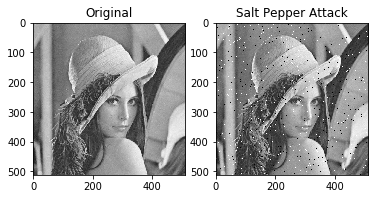

In [4]:
test.add_salt_pepper_noise("watermarked_lena.jpg", prob = 0.01)
test.plot_image("watermarked_lena.jpg", "salt_pepper_noise_attack.jpg", 'Salt Pepper Attack')

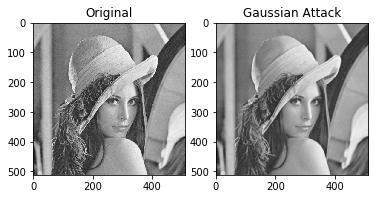

In [5]:
test.add_gaussian_noise("watermarked_lena.jpg")
test.plot_image("watermarked_lena.jpg", 'gaussian_noise_attack.jpg', 'Gaussian Attack')

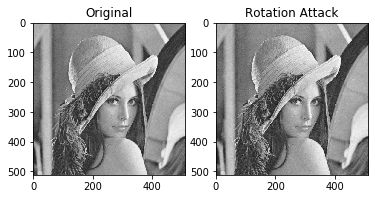

In [6]:
test.add_rotation_test(0, "watermarked_lena.jpg")
test.plot_image("watermarked_lena.jpg", "rotation_attack.jpg", 'Rotation Attack')

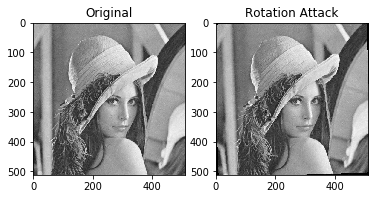

In [7]:
test.add_rotation_test(2, "watermarked_lena.jpg")
test.plot_image("watermarked_lena.jpg", "rotation_attack.jpg", 'Rotation Attack')

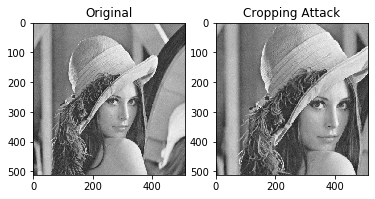

In [8]:
test.rescale_test("watermarked_lena.jpg")
test.plot_image("watermarked_lena.jpg", "cropped_attack.jpg", 'Cropping Attack') 

In [9]:
test.testing("watermarked_lena.jpg")

For  Gaussian Noise Attack
PSNR:  30.7033171881248 NC:  0.42925141902382635
For  Salt and Pepper Noise Attack
PSNR:  22.367745806751316 NC:  0.4287954816760343
For  Rotation Attack
PSNR:  17.401459854214895 NC:  0.4296499749038721
For  Crop Attack
PSNR:  11.565835078834558 NC:  0.4296796971390806


In [10]:
test.rotate("watermarked_lena.jpg")

Degree:  -90  ---PSNR:  10.711547557561689 ---NC:  0.4297193110794776
Degree:  -80  ---PSNR:  10.17678373914665 ---NC:  0.42900767678239665
Degree:  -70  ---PSNR:  9.788354026006477 ---NC:  0.4302568333681076
Degree:  -60  ---PSNR:  9.605319433841652 ---NC:  0.42913898684595597
Degree:  -50  ---PSNR:  9.774188784084785 ---NC:  0.42996829808428955
Degree:  -40  ---PSNR:  9.823604138676318 ---NC:  0.4302130389720763
Degree:  -30  ---PSNR:  9.971777684242099 ---NC:  0.43047077806583134
Degree:  -20  ---PSNR:  10.555119571946797 ---NC:  0.4303776885026498
Degree:  -10  ---PSNR:  11.735397224794156 ---NC:  0.42933900344977544
Degree:  0  ---PSNR:  42.17754619379721 ---NC:  0.4302531510377632
Degree:  10  ---PSNR:  11.861399121531562 ---NC:  0.4297490029197945
Degree:  20  ---PSNR:  10.608242612399252 ---NC:  0.42959296558525184
Degree:  30  ---PSNR:  10.038653690568044 ---NC:  0.4301459409833617
Degree:  40  ---PSNR:  9.867507980172308 ---NC:  0.4289772950935748
Degree:  50  ---PSNR:  9.732